In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# Data Preprocess

In [2]:
# Data from 2017-05-10 to 2024-04-19
li2co3 = pd.read_csv(r'/content/Lithium Carbonate 99%Min China Spot Historical Data (5).csv')
li2co3['Date'] = pd.to_datetime(li2co3['Date'])
# The date order need to be inverted (from early to late)
li2co3 = li2co3.sort_values('Date')
li2co3.set_index('Date', inplace=True)
li2co3 = pd.DataFrame(li2co3["Price"])


li2co3['Price'] = (li2co3['Price'].str.replace(",","").astype(float))
na_count = li2co3['Price'].isna().sum()
print("Number of missing values:", na_count)
if na_count > 0:
  li2co3 = li2co3.dropna(subset=['Price'])

# daily log returns
li2co3['log_ret'] = np.log(li2co3['Price']).diff()
li2co3 = li2co3.dropna(subset=['log_ret'])

Number of missing values: 0


In [3]:
li2co3.head(10)

,Price,log_ret
Date,,
2017-05-11,123000.0,0.000000
2017-05-12,123000.0,0.000000
2017-05-15,123000.0,0.000000
2017-05-16,123000.0,0.000000
2017-05-17,123000.0,0.000000
2017-05-18,123000.0,0.000000
2017-05-19,124000.0,0.008097
2017-05-22,124000.0,0.000000
2017-05-23,124000.0,0.000000


In [4]:
li2co3.tail(10)

,Price,log_ret
Date,,
2024-04-08,109500.0,0.027780
2024-04-09,109500.0,0.000000
2024-04-10,110500.0,0.009091
2024-04-11,109500.0,-0.009091
2024-04-12,109500.0,0.000000
2024-04-15,109500.0,0.000000
2024-04-16,109500.0,0.000000
2024-04-17,109500.0,0.000000
2024-04-18,109500.0,0.000000


# Weekly log return series and zero count series

In [5]:
Fridays = pd.DataFrame()
Thursdays = pd.DataFrame()
Wednesdays = pd.DataFrame()
Tuesdays = pd.DataFrame()
Mondays = pd.DataFrame()

In [6]:
def weekly_returns(data, chosen_day):
    # chosen_day = ['W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-FRI']
    weekly_log_return = data.groupby(pd.Grouper(freq=chosen_day))['log_ret'].sum()
    weekly_log_return = weekly_log_return.dropna()
    return weekly_log_return

If use your function groupby(freq='M'), there will be no differences at monthly zero between Fir to Fri and Thur to Thur, etc.

In [7]:
def count_zero(df, chosen_day):
    # chosen_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    # Create a zero dummy series: 1 if 'log_ret' is zero, 0 otherwise
    data = df.copy()
    data['zero_dummy'] = (data['log_ret'] == 0).astype(int)
    # Compute the sum of past 22 days and past 5 days for zero_dummy
    data['zero_count_22'] = data['zero_dummy'].rolling(window=22).sum()
    data['zero_count_5'] = data['zero_dummy'].rolling(window=5).sum()
    data = data.dropna()
    # Extract chosen day
    data['day_of_week'] = data.index.day_name()
    chosendays_data = data[data['day_of_week'] == chosen_day]

    # Select only the zero count columns and the index for Fridays
    chosendays_data = chosendays_data[['zero_count_22', 'zero_count_5']]
    chosendays_data['zero_count_22'] = chosendays_data['zero_count_22'].astype(int)
    chosendays_data['zero_count_5'] = chosendays_data['zero_count_5'].astype(int)
    return chosendays_data

In [8]:
# Friday to Friday
Fridays['Log_Return'] = weekly_returns(li2co3, 'W-FRI')
Fridays['Zero_Count_22'] = count_zero(li2co3, 'Friday')['zero_count_22']
Fridays['Zero_Count_5'] = count_zero(li2co3, 'Friday')['zero_count_5']
Fridays = Fridays.dropna()

# Thursday to Thursday
Thursdays['Log_Return'] = weekly_returns(li2co3, 'W-THU')
Thursdays['Zero_Count_22'] = count_zero(li2co3, 'Thursday')['zero_count_22']
Thursdays['Zero_Count_5'] = count_zero(li2co3, 'Thursday')['zero_count_5']
Thursdays = Thursdays.dropna()

# Wednesday to Wednesday
Wednesdays['Log_Return'] = weekly_returns(li2co3, 'W-WED')
Wednesdays['Zero_Count_22'] = count_zero(li2co3, 'Wednesday')['zero_count_22']
Wednesdays['Zero_Count_5'] = count_zero(li2co3, 'Wednesday')['zero_count_5']
Wednesdays = Wednesdays.dropna()

# Tuesday to Tuesday
Tuesdays['Log_Return'] = weekly_returns(li2co3, 'W-TUE')
Tuesdays['Zero_Count_22'] = count_zero(li2co3, 'Tuesday')['zero_count_22']
Tuesdays['Zero_Count_5'] = count_zero(li2co3, 'Tuesday')['zero_count_5']
Tuesdays = Tuesdays.dropna()

# Monday to Monday
Mondays['Log_Return'] = weekly_returns(li2co3, 'W-MON')
Mondays['Zero_Count_22'] = count_zero(li2co3, 'Monday')['zero_count_22']
Mondays['Zero_Count_5'] = count_zero(li2co3, 'Monday')['zero_count_5']
Mondays = Mondays.dropna()

<ipython-input-7-0eb9554b1237>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_of_week'] = data.index.day_name()


In [9]:
print("Friday to Firday")
print(Fridays.tail(10))
print("Thursday to Thursday")
print(Thursdays.tail(10))
print("Wednesday to Wednesday")
print(Wednesdays.tail(10))
print("Tuesday to Tuesday")
print(Tuesdays.tail(10))
print("Monday to Monday")
print(Mondays.tail(10))

Friday to Firday
            Log_Return  Zero_Count_22  Zero_Count_5
Date                                               
2024-01-26    0.000000           22.0           5.0
2024-02-02    0.000000           22.0           5.0
2024-02-23   -0.005666           20.0           4.0
2024-03-01    0.092206           16.0           1.0
2024-03-08    0.050516           14.0           3.0
2024-03-15    0.038652           10.0           0.0
2024-03-22    0.028039            8.0           2.0
2024-03-29   -0.037563            7.0           2.0
2024-04-12    0.027780            7.0           2.0
2024-04-19    0.000000           12.0           5.0
Thursday to Thursday
            Log_Return  Zero_Count_22  Zero_Count_5
Date                                               
2024-01-25    0.000000           22.0           5.0
2024-02-01    0.000000           22.0           5.0
2024-02-22   -0.005666           20.0           4.0
2024-02-29    0.071263           17.0           2.0
2024-03-07    0.071459    

# Summary statistics

In [10]:
summary_statistics_Fridays = Fridays.describe().loc[['mean', 'min', 'max', 'std']]
summary_statistics_Thursdays = Thursdays.describe().loc[['mean', 'min', 'max', 'std']]
summary_statistics_Wednesdays = Wednesdays.describe().loc[['mean', 'min', 'max', 'std']]
summary_statistics_Tuesdays = Tuesdays.describe().loc[['mean', 'min', 'max', 'std']]
summary_statistics_Mondays = Mondays.describe().loc[['mean', 'min', 'max', 'std']]

print("Friday to Firday")
print(summary_statistics_Fridays)
print("Thursday to Thursday")
print(summary_statistics_Thursdays)
print("Wednesday to Wednesday")
print(summary_statistics_Wednesdays)
print("Tuesday to Tuesday")
print(summary_statistics_Tuesdays)
print("Monday to Monday")
print(summary_statistics_Mondays)

Friday to Firday
      Log_Return  Zero_Count_22  Zero_Count_5
mean   -0.000397      15.089783      3.421053
min    -0.152469       0.000000      0.000000
max     0.267022      22.000000      5.000000
std     0.044616       5.608998      1.584804
Thursday to Thursday
      Log_Return  Zero_Count_22  Zero_Count_5
mean   -0.000692      15.096386      3.418675
min    -0.172141       0.000000      0.000000
max     0.204501      22.000000      5.000000
std     0.044082       5.556335      1.576646
Wednesday to Wednesday
      Log_Return  Zero_Count_22  Zero_Count_5
mean   -0.000154      15.036145      3.418675
min    -0.190575       0.000000      0.000000
max     0.252326      22.000000      5.000000
std     0.044743       5.529806      1.533911
Tuesday to Tuesday
      Log_Return  Zero_Count_22  Zero_Count_5
mean   -0.000803      15.026946      3.410180
min    -0.163827       0.000000      0.000000
max     0.298955      22.000000      5.000000
std     0.045178       5.532529      1.552684


# Autocorrelogram and partial autocorrelogram for daily return

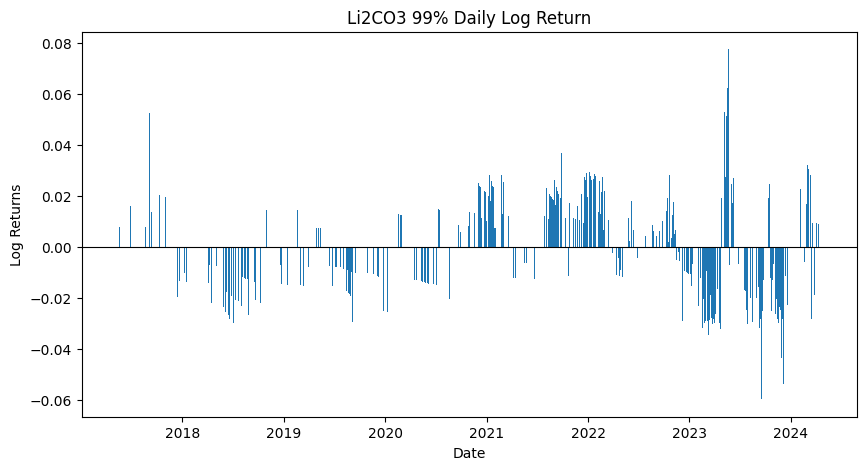

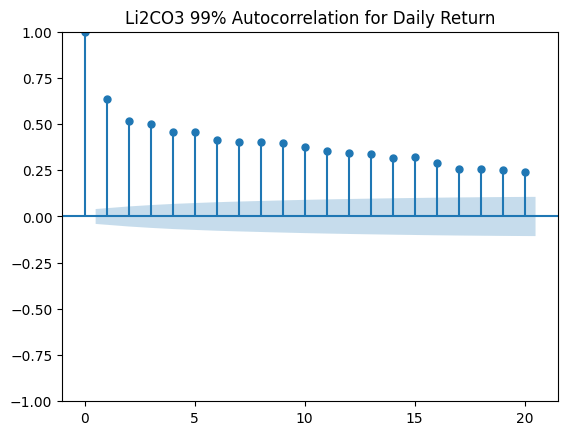

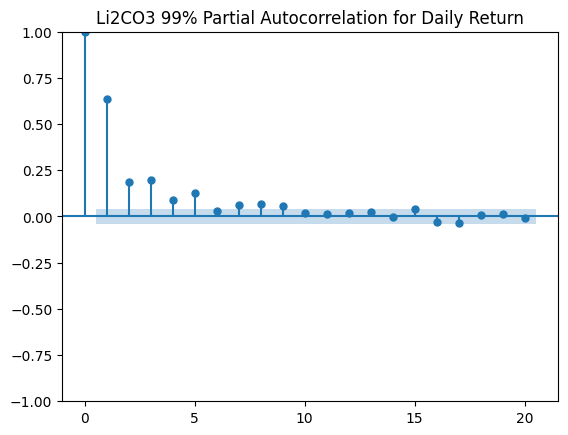

In [11]:
# Daily return
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.bar(li2co3.index, li2co3['log_ret'], width=2.5)
plt.axhline(0, linewidth=0.8, color='k')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Li2CO3 99% Daily Log Return')
plt.show()

# Plot autocorrelation and partial autocorrelation
acf = plot_acf(li2co3['log_ret'], lags=20, alpha=0.1, title='Li2CO3 99% Autocorrelation for Daily Return')
pacf = plot_pacf(li2co3['log_ret'], lags=20, alpha=0.1, method='ywm', title='Li2CO3 99% Partial Autocorrelation for Daily Return')

# Autocorrelogram and partial autocorrelogram for weekly return (use Fridays as example)

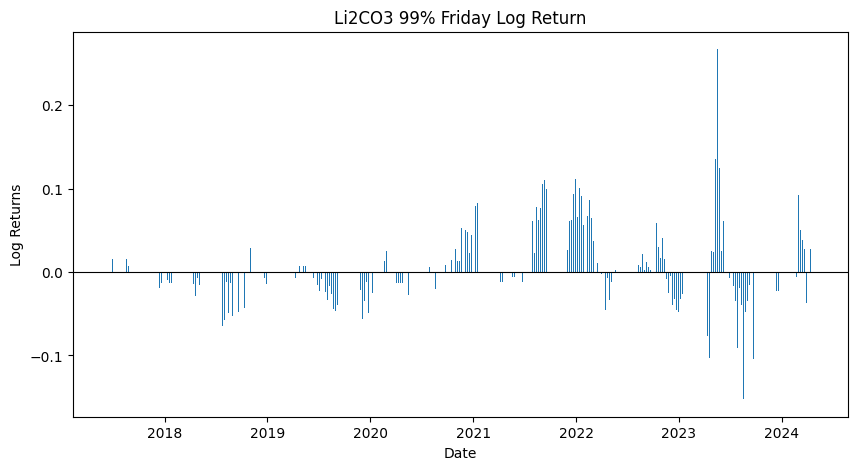

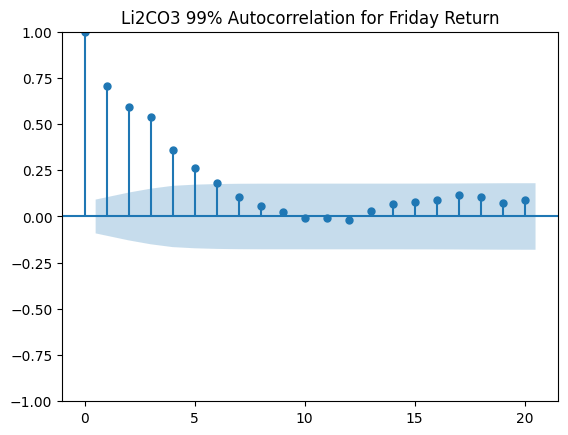

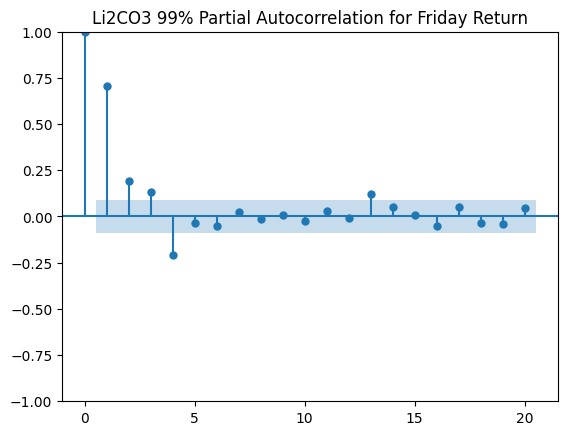

In [25]:
# Weekly return, use Friday to Friday as example
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.bar(Fridays.index, Fridays['Log_Return'], width=2.5)
plt.axhline(0, linewidth=0.8, color='k')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Li2CO3 99% Friday Log Return')
plt.show()

# Plot autocorrelation and partial autocorrelation
acf = plot_acf(Fridays['Log_Return'], lags=20, alpha=0.1, title='Li2CO3 99% Autocorrelation for Friday Return')
pacf = plot_pacf(Fridays['Log_Return'], lags=20, alpha=0.1, method='ywm', title='Li2CO3 99% Partial Autocorrelation for Friday Return')

# Two AR(2) models for daily return

In [13]:
def estimate_ar2_model(df, lags):
    """
    Estimate a basic AR(2) model for returns.

    Parameters:
    - data: DataFrame containing the log returns series under 'log_ret'.
    - lags: Number of lags to use for HAC standard errors.

    Returns:
    - model: OLS regression results containing the fitted model.
    """

    data = df.copy()
    data['log_ret_lag1'] = data['log_ret'].shift(1)
    data['log_ret_lag2'] = data['log_ret'].shift(2)

    data.dropna(inplace=True)

    # Define the variables and add a constant term for the intercept (alpha)
    X = data[['log_ret_lag1', 'log_ret_lag2']]
    X = sm.add_constant(X)  # Adds a constant column to input data set
    Y = data['log_ret']

    # Fit the AR(2) model
    model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})

    return model

In [14]:
# lags=5 acording to the daily pacf
daily_return_ar2_model = estimate_ar2_model(li2co3, lags=5)

In [15]:
print(daily_return_ar2_model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ret   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     188.0
Date:                Sat, 27 Apr 2024   Prob (F-statistic):           2.62e-74
Time:                        16:07:36   Log-Likelihood:                 5540.0
No. Observations:                1662   AIC:                        -1.107e+04
Df Residuals:                    1659   BIC:                        -1.106e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.075e-05      0.000     -0.104   

In [16]:
def estimate_ar2_model_with_zero_dummy(df, lags):
    """
    Estimate an AR(2) model for log returns with modifications to account for zero dummies.

    Parameters:
    - data: DataFrame containing the log returns 'log_ret'.
    - lags: Number of lags to use for HAC standard errors.

    Returns:
    - model: OLS regression results containing the fitted model.
    """

    data = df.copy()
    data['zero_dummy'] = (data['log_ret'] == 0).astype(int)

    # Generate lagged return series
    data['log_ret_lag1'] = data['log_ret'].shift(1)
    data['log_ret_lag2'] = data['log_ret'].shift(2)

    # Generate interaction terms
    data['log_ret_lag1_zero'] = data['log_ret_lag1'] * data['zero_dummy']
    data['log_ret_lag2_zero'] = data['log_ret_lag2'] * data['zero_dummy']

    data.dropna(inplace=True)

    # Define the new model with additional interaction terms
    X = data[['zero_dummy', 'log_ret_lag1', 'log_ret_lag2', 'log_ret_lag1_zero', 'log_ret_lag2_zero']]
    X = sm.add_constant(X)
    Y = data['log_ret']

    # Fit the AR(2) model
    model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})

    return model

In [17]:
# lags=5 acording to the daily pacf
daily_return_ar2_model_with_zero_dummy = estimate_ar2_model_with_zero_dummy(li2co3, lags = 5)

In [18]:
print(daily_return_ar2_model_with_zero_dummy.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ret   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     442.3
Date:                Sat, 27 Apr 2024   Prob (F-statistic):          5.35e-211
Time:                        16:07:42   Log-Likelihood:                 5856.5
No. Observations:                1662   AIC:                        -1.170e+04
Df Residuals:                    1656   BIC:                        -1.167e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0010      0.00

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '


# Two AR(2) models for weekly return (use Fridays as example)

In [19]:
def estimate_ar2_model(df, lags):
    """
    Estimate a basic AR(2) model for returns.

    Parameters:
    - data: DataFrame containing the log returns series under 'Log_Return'.
    - lags: Number of lags to use for HAC standard errors.

    Returns:
    - model: OLS regression results containing the fitted model.
    """

    data = df.copy()
    data['log_ret_lag1'] = data['Log_Return'].shift(1)
    data['log_ret_lag2'] = data['Log_Return'].shift(2)

    data.dropna(inplace=True)

    # Define the variables and add a constant term for the intercept (alpha)
    X = data[['log_ret_lag1', 'log_ret_lag2']]
    X = sm.add_constant(X)  # Adds a constant column to input data set
    Y = data['Log_Return']

    # Fit the AR(2) model
    model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})

    return model

In [26]:
# lags=4 acording to the Friday pacf
fridays_return_ar2_model = estimate_ar2_model(Fridays, lags=4)

In [27]:
print(fridays_return_ar2_model.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     84.51
Date:                Sat, 27 Apr 2024   Prob (F-statistic):           3.69e-30
Time:                        16:11:06   Log-Likelihood:                 658.66
No. Observations:                 321   AIC:                            -1311.
Df Residuals:                     318   BIC:                            -1300.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.831e-05      0.002     -0.044   

In [22]:
def estimate_ar2_model_with_zero_count(df, lags):
    """
    Estimate an AR(2) model for weekly log returns, incorporating two zero count series and their interaction effects,
    and allowing for specification of lags for HAC standard errors.

    Parameters:
    - data: DataFrame containing the weekly log returns under 'Log_Return', and two zero count series 'Zero_Count_22' and 'Zero_Count_5'.
    - lags: Maximum number of lags to use for HAC standard errors.

    Returns:
    - model: OLS regression results containing the fitted model with HAC standard errors.
    """

    data = df.copy()
    # Generate lagged return series
    data['Log_Return_Lag1'] = data['Log_Return'].shift(1)
    data['Log_Return_Lag2'] = data['Log_Return'].shift(2)

    # Generate interaction terms for lagged returns and zero counts
    data['Log_Return_Lag1_Zero22'] = data['Log_Return_Lag1'] * data['Zero_Count_22']
    data['Log_Return_Lag2_Zero22'] = data['Log_Return_Lag2'] * data['Zero_Count_22']
    data['Log_Return_Lag1_Zero5'] = data['Log_Return_Lag1'] * data['Zero_Count_5']
    data['Log_Return_Lag2_Zero5'] = data['Log_Return_Lag2'] * data['Zero_Count_5']

    # Interaction between zero count series
    data['Zero22_Zero5_Interaction'] = data['Zero_Count_22'] * data['Zero_Count_5']

    # Drop any rows with NaN values that were created by lagging
    data.dropna(inplace=True)

    # Define the model with additional interaction terms
    X = data[['Zero_Count_22', 'Zero_Count_5', 'Zero22_Zero5_Interaction',
              'Log_Return_Lag1', 'Log_Return_Lag2',
              'Log_Return_Lag1_Zero22', 'Log_Return_Lag2_Zero22',
              'Log_Return_Lag1_Zero5', 'Log_Return_Lag2_Zero5']]
    X = sm.add_constant(X)
    y = data['Log_Return']

    # Fit the AR(2) model with HAC standard errors
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})

    return model


In [28]:
# lags=4 acording to the Friday pacf
fridays_return_ar2_model_with_zero_count = estimate_ar2_model_with_zero_count(Fridays, lags=4)

In [29]:
print(fridays_return_ar2_model_with_zero_count.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     68.38
Date:                Sat, 27 Apr 2024   Prob (F-statistic):           1.99e-68
Time:                        16:11:11   Log-Likelihood:                 731.96
No. Observations:                 321   AIC:                            -1444.
Df Residuals:                     311   BIC:                            -1406.
Df Model:                           9                                         
Covariance Type:                  HAC                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

# Try other day regions

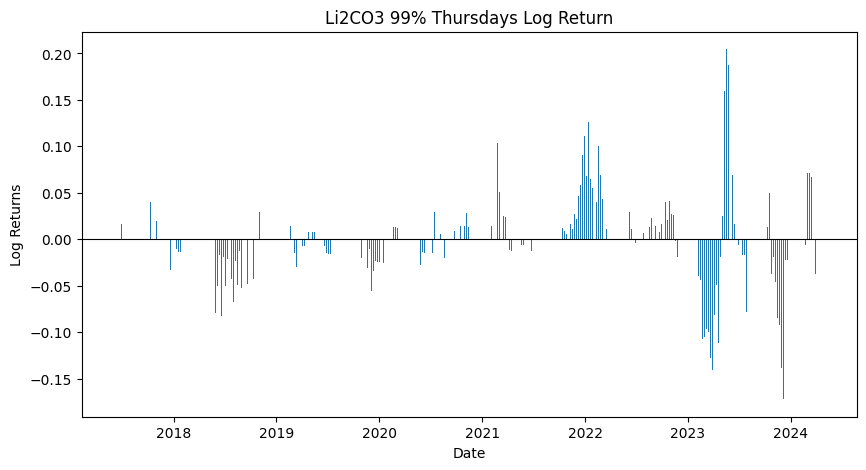

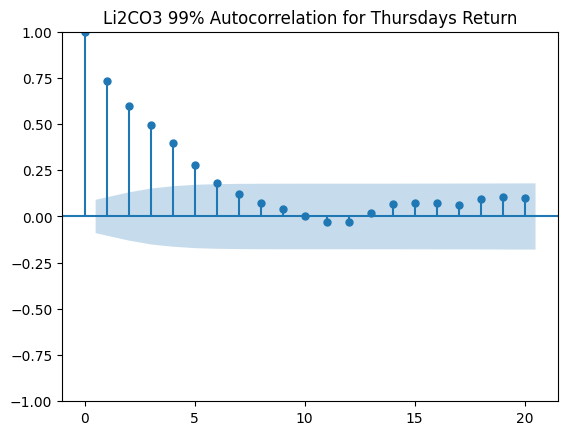

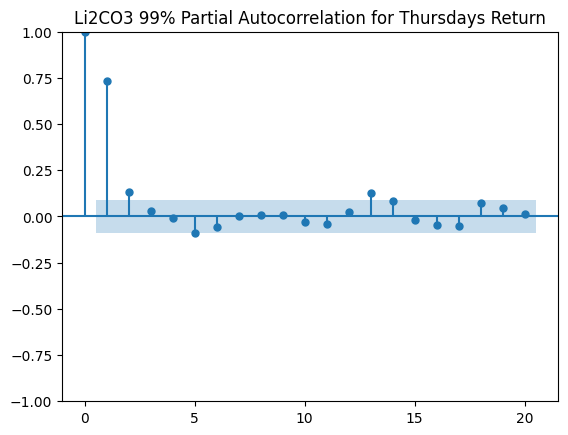

In [30]:
# Thursday to Thursday
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.bar(Thursdays.index, Thursdays['Log_Return'], width=2.5)
plt.axhline(0, linewidth=0.8, color='k')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Li2CO3 99% Thursdays Log Return')
plt.show()

# Plot autocorrelation and partial autocorrelation
acf = plot_acf(Thursdays['Log_Return'], lags=20, alpha=0.1, title='Li2CO3 99% Autocorrelation for Thursdays Return')
pacf = plot_pacf(Thursdays['Log_Return'], lags=20, alpha=0.1, method='ywm', title='Li2CO3 99% Partial Autocorrelation for Thursdays Return')

In [31]:
# lags=2 acording to the Thursdays pacf
thursdays_return_ar2_model_with_zero_count = estimate_ar2_model_with_zero_count(Thursdays, lags=2)

print(thursdays_return_ar2_model_with_zero_count.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     62.81
Date:                Sat, 27 Apr 2024   Prob (F-statistic):           1.93e-65
Time:                        16:14:15   Log-Likelihood:                 767.08
No. Observations:                 330   AIC:                            -1514.
Df Residuals:                     320   BIC:                            -1476.
Df Model:                           9                                         
Covariance Type:                  HAC                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

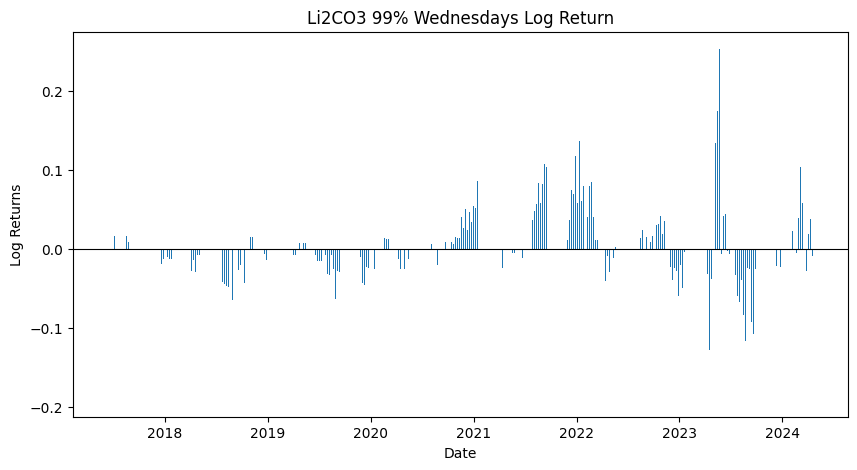

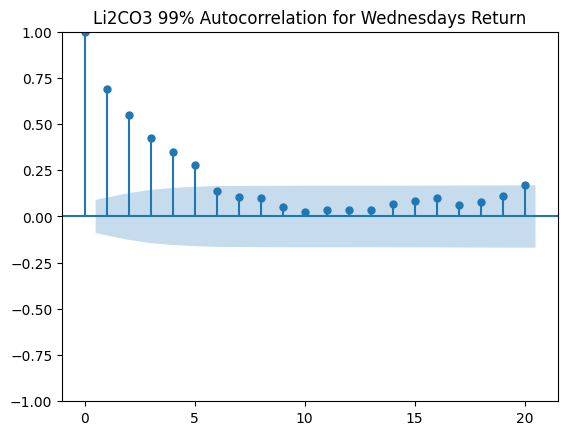

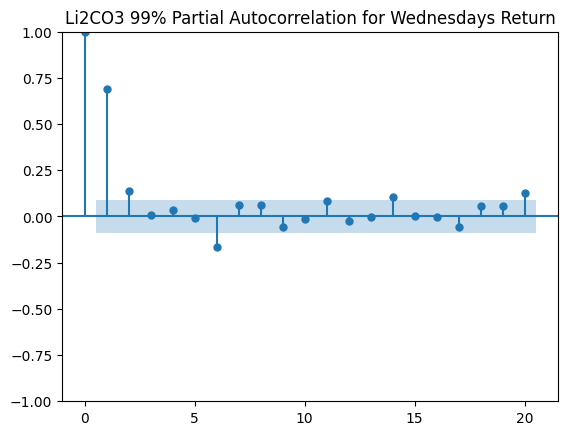

In [32]:
# Wednesday to Wednesday
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.bar(Wednesdays.index, Wednesdays['Log_Return'], width=2.5)
plt.axhline(0, linewidth=0.8, color='k')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Li2CO3 99% Wednesdays Log Return')
plt.show()

# Plot autocorrelation and partial autocorrelation
acf = plot_acf(Wednesdays['Log_Return'], lags=20, alpha=0.1, title='Li2CO3 99% Autocorrelation for Wednesdays Return')
pacf = plot_pacf(Wednesdays['Log_Return'], lags=20, alpha=0.1, method='ywm', title='Li2CO3 99% Partial Autocorrelation for Wednesdays Return')

In [33]:
# lags=2 acording to the Wednesdays  pacf
wednesdays_return_ar2_model_with_zero_count = estimate_ar2_model_with_zero_count(Wednesdays, lags=2)

print(wednesdays_return_ar2_model_with_zero_count.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     41.81
Date:                Sat, 27 Apr 2024   Prob (F-statistic):           5.23e-49
Time:                        16:16:52   Log-Likelihood:                 757.16
No. Observations:                 330   AIC:                            -1494.
Df Residuals:                     320   BIC:                            -1456.
Df Model:                           9                                         
Covariance Type:                  HAC                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

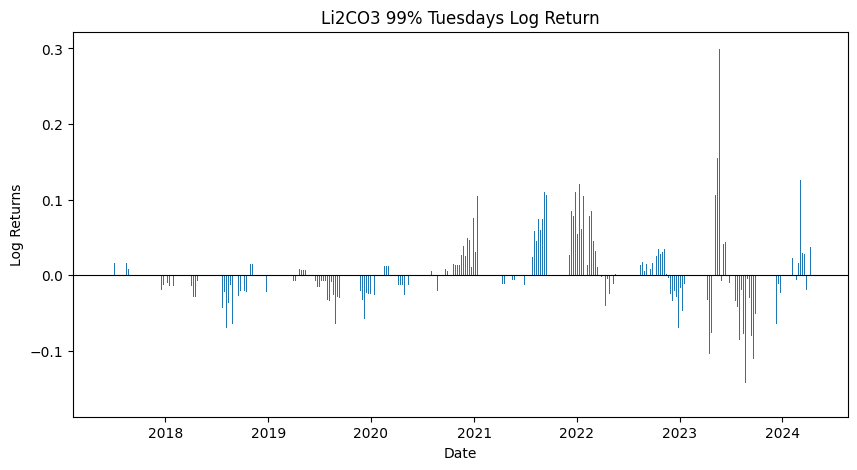

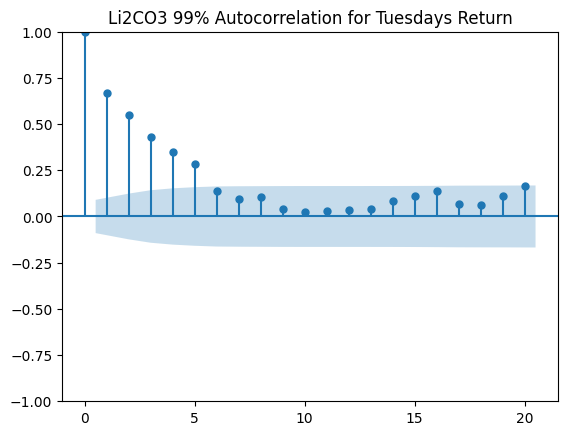

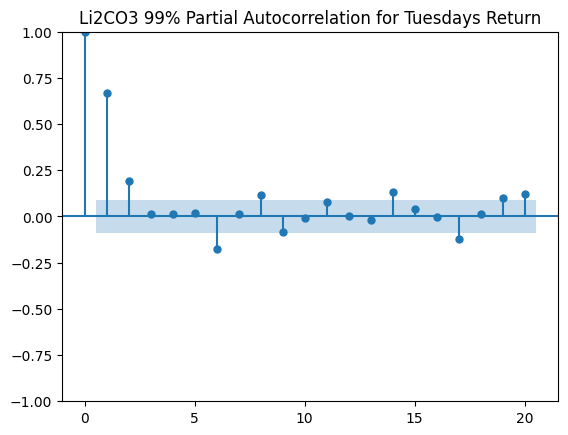

In [34]:
# Tuesday to Tuesday
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.bar(Tuesdays.index, Tuesdays['Log_Return'], width=2.5)
plt.axhline(0, linewidth=0.8, color='k')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Li2CO3 99% Tuesdays Log Return')
plt.show()

# Plot autocorrelation and partial autocorrelation
acf = plot_acf(Tuesdays['Log_Return'], lags=20, alpha=0.1, title='Li2CO3 99% Autocorrelation for Tuesdays Return')
pacf = plot_pacf(Tuesdays['Log_Return'], lags=20, alpha=0.1, method='ywm', title='Li2CO3 99% Partial Autocorrelation for Tuesdays Return')

In [35]:
# lags=2 acording to the Tuesdays pacf
tuesdays_return_ar2_model_with_zero_count = estimate_ar2_model_with_zero_count(Tuesdays, lags=2)

print(tuesdays_return_ar2_model_with_zero_count.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     49.80
Date:                Sat, 27 Apr 2024   Prob (F-statistic):           7.60e-56
Time:                        16:21:52   Log-Likelihood:                 761.44
No. Observations:                 332   AIC:                            -1503.
Df Residuals:                     322   BIC:                            -1465.
Df Model:                           9                                         
Covariance Type:                  HAC                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

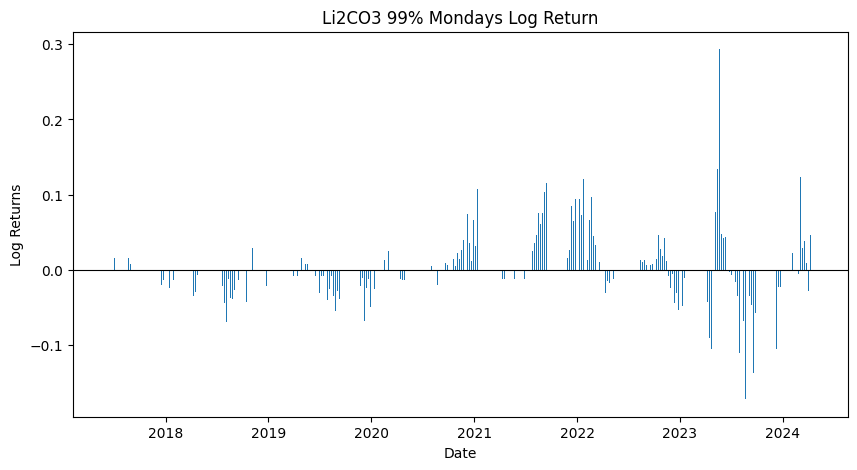

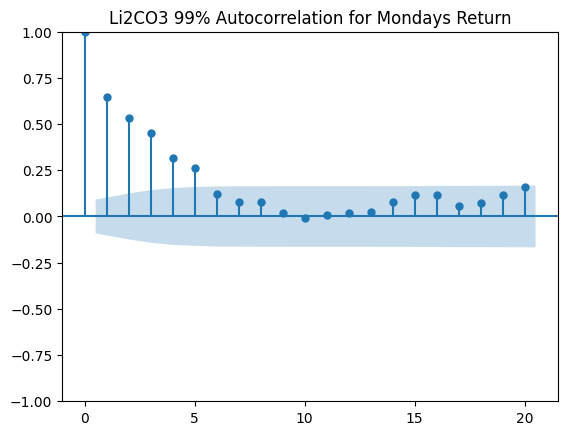

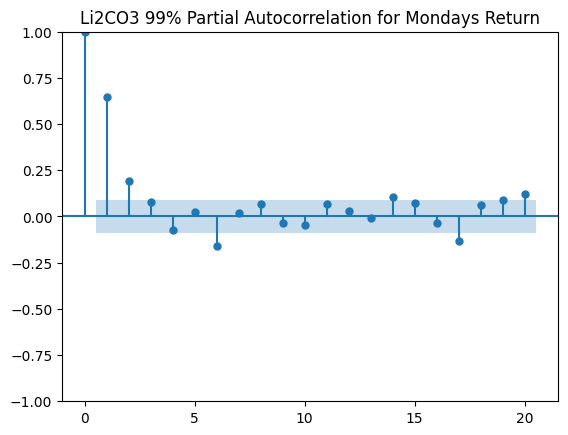

In [36]:
# Monday to Monday
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.bar(Mondays.index, Mondays['Log_Return'], width=2.5)
plt.axhline(0, linewidth=0.8, color='k')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Li2CO3 99% Mondays Log Return')
plt.show()

# Plot autocorrelation and partial autocorrelation
acf = plot_acf(Mondays['Log_Return'], lags=20, alpha=0.1, title='Li2CO3 99% Autocorrelation for Mondays Return')
pacf = plot_pacf(Mondays['Log_Return'], lags=20, alpha=0.1, method='ywm', title='Li2CO3 99% Partial Autocorrelation for Mondays Return')

In [37]:
# lags=2 acording to the Mondays pacf
mondays_return_ar2_model_with_zero_count = estimate_ar2_model_with_zero_count(Mondays, lags=2)

print(mondays_return_ar2_model_with_zero_count.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     38.00
Date:                Sat, 27 Apr 2024   Prob (F-statistic):           3.99e-45
Time:                        16:22:17   Log-Likelihood:                 703.92
No. Observations:                 320   AIC:                            -1388.
Df Residuals:                     310   BIC:                            -1350.
Df Model:                           9                                         
Covariance Type:                  HAC                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   